In [1]:
import json
import pandas as pd
from typing import Dict, Tuple, List
import os, sys
from model.indexer import Indexer
from model.indexer import load_amr_config

amr, slot, task, precedence = load_amr_config("data/amr1_slots2_task1.json")
print(amr)
print(slot)
print(task)
print(precedence)

['R1']
[0, 1]
[{'name': 'T1', 'p': 1}]
[['T1', 'T3'], ['T2', 'T3']]


In [2]:
from model.indexer import assign_ent_to_indexer
indexer = Indexer()
indexer_, x, y, w = assign_ent_to_indexer(indexer, amr, slot, task)
def indexer_to_dataframe(indexer):
    data = []
    for idx, key in enumerate(indexer._from_idx):
        data.append({"index": idx, "variable": key})
    df = pd.DataFrame(data)
    return df
df = indexer_to_dataframe(indexer)
print(df)

   index        variable
0      0     (x, T1, R1)
1      1      (y, T1, 0)
2      2      (y, T1, 1)
3      3  (w, T1, R1, 0)
4      4  (w, T1, R1, 1)


In [3]:
from model.qubo_builder import QuboBuilder
qb = QuboBuilder(indexer)

In [4]:
from model.objectives.makespan import add_makespan_objective
from model.objectives.balance import add_workload_balance_objective
w_makespan = 1.0
w_balance = 0.5
add_makespan_objective(qb, task, slot, y, w_makespan)
#add_workload_balance_objective(qb, task, amr, x, w_balance)
df = qb.to_dataframe(use_labels=True)
#print(df)

In [5]:
from model.constraints import c1
c1.add_startslot_exactly_one_constraints(qb, task, slot, y, lam_c1=35.0) 

In [7]:
from model.constraints import c3_
c3_.add_c3_capacity_no_overlap(qb, task, amr, slot, x, y, w, lam_c3_and=20, lam_c3_cap=20)

In [8]:
from model.constraints import c4
c4.add_c4_consistency_inline(qb, task, amr, slot, x, y, lam_c4=0)

In [8]:
from model.constraints import c2
c2.add_assignment_exactly_one_constraints(qb, task, amr, x, lam_c2=35)

In [9]:
print(qb.Q)

defaultdict(<class 'float'>, {(1, 1): -34.0, (2, 2): -31.0, (1, 2): 70.0, (3, 3): 120.0, (0, 3): -120.0, (1, 3): -40.0, (4, 4): 120.0, (0, 4): -120.0, (2, 4): -40.0, (3, 4): 80.0, (0, 0): 5.0})


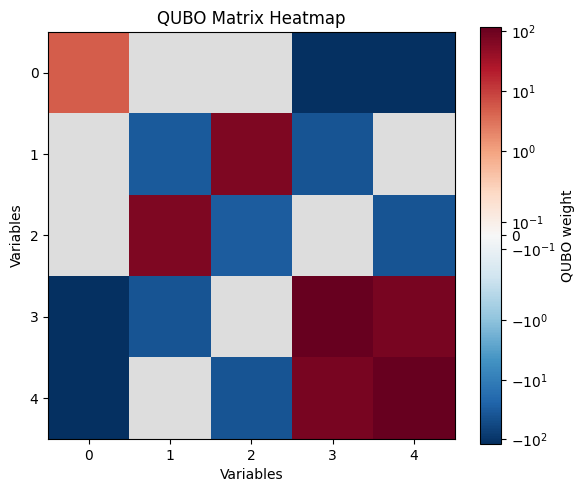

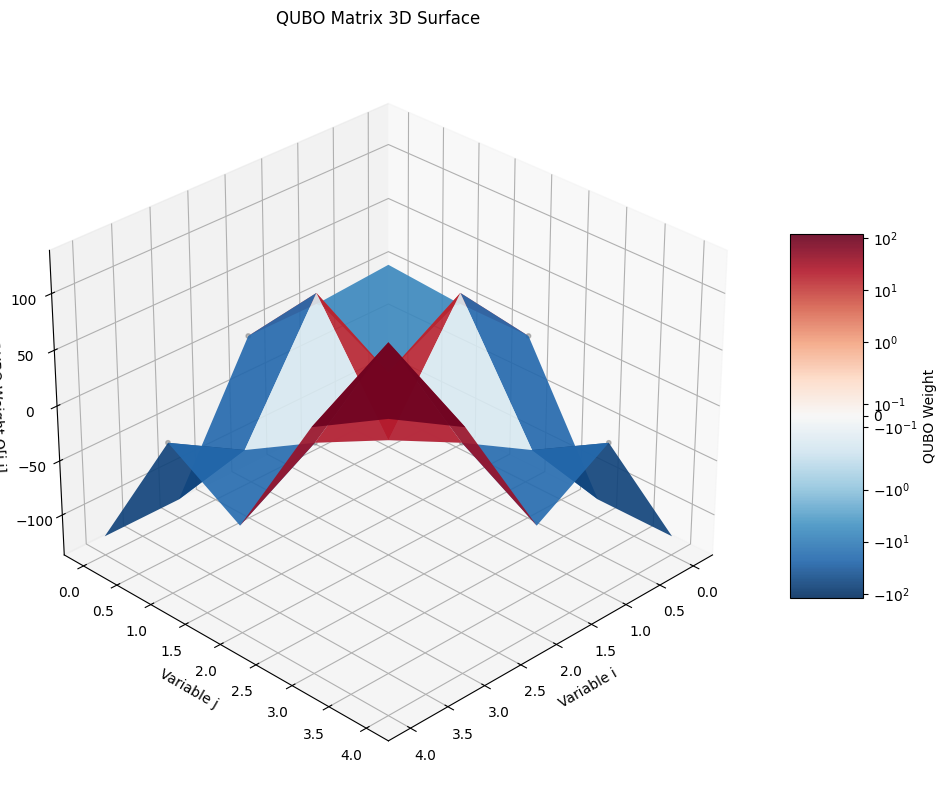

(<Figure size 1000x800 with 2 Axes>,
 <Axes3D: title={'center': 'QUBO Matrix 3D Surface'}, xlabel='Variable i', ylabel='Variable j', zlabel='QUBO Weight Q[i,j]'>)

In [10]:
import old.plot_qb_heatmap as plot_qb_heatmap
import importlib
importlib.reload(plot_qb_heatmap)
df = qb.to_dataframe(use_labels=True)
plot_qb_heatmap.plot_qubo_heatmap(df, labels=df.columns.tolist(),linthresh=0.5, tiny_mark=0.1, vmax_pct=99.5)
plot_qb_heatmap.plot_qubo_3d_surface(df)

In [ ]:
import importlib
from model.constraints import c1, c2, c3_, c4, c5
#importlib.reload(c3)
lam_c1 = 50
lam_c2 = 50
lam3_and = 15
lam3_cap = 15
lam_c4 = 1
lam_c5 = 4

c1.add_startslot_exactly_one_constraints(qb, task, slot, y, lam_c1) 
c2.add_assignment_exactly_one_constraints(qb, task, amr, x, lam_c2) 
c3_.add_c3_capacity_no_overlap_inline(qb, task, amr, slot, x, y, w, lam3_and, lam3_cap)
c4.add_c4_consistency_inline(qb, task, amr, slot, x, y, lam_c4)
c5.add_c5_precedence_inline(qb, task, slot, y, precedence, lam_c5)

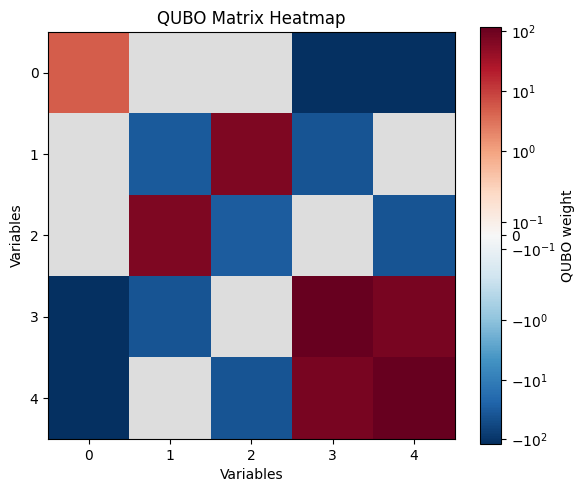

In [11]:
importlib.reload(plot_qb_heatmap)
df = qb.to_dataframe(use_labels=True)
plot_qb_heatmap.plot_qubo_heatmap(df, labels=df.columns.tolist(),linthresh=0.5, tiny_mark=0.1, vmax_pct=99.5)

In [12]:

import numpy as np
df = qb.to_dataframe()
H_obj = df.filter(like='objective')  # falls du sie getaggt hast
print("QUBO absolute values:", np.percentile(np.abs(df.values), [5,50,95]))

QUBO absolute values: [  0.  40. 120.]


In [ ]:
import dimod, neal
Q = dict(qb.Q) 
Q_upper = {(i, j): w for (i, j), w in Q.items() if i <= j}
bqm = dimod.BinaryQuadraticModel.from_qubo(Q_upper)
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=5000, sweeps=20000, beta_range=(0.1, 10.0), seed=123)
print(sampleset)
asym = [((i,j), w - Q.get((j,i),0.0)) for (i,j), w in Q.items() if i>j and abs(w - Q.get((j,i),0.0))>1e-9]
print("Asymmetrien:", len(asym))
E_neal = sampleset.lowest().first.energy
print(E_neal)

In [ ]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer
Q = dict(qb.Q)
Q_upper = {(i, j): w for (i, j), w in Q.items() if i <= j}
n = max(max(i, j) for (i, j) in Q.keys()) + 1
qp = QuadraticProgram()
qp.binary_var_list(n)
linear = {}
quadratic = {}
for (i, j), weight in Q.items():
    if i == j:
        linear[i] = linear.get(i, 0.0) + weight
    else:
        a, b = (i, j) if i < j else (j, i)
        quadratic[(a, b)] = quadratic.get((a, b), 0.0) + weight
qp.minimize(linear=linear, quadratic=quadratic)
optimizer = CplexOptimizer()
result = optimizer.solve(qp)
print(result)            
print("Objektwert:", result.fval)
print("Lösung x:", result.x)

# Wenn du die Lösung als Dict möchtest (Index -> 0/1):
solution = {i: int(round(v)) for i, v in enumerate(result.x)}
print("Lösung (Dict):", solution)


In [13]:
from qiskit_optimization import QuadraticProgram
from qiskit.quantum_info import SparsePauliOp

Q = dict(qb.Q)
n = max(max(i, j) for (i, j) in Q.keys()) + 1
qp = QuadraticProgram()
qp.binary_var_list(n)
linear = {}
quadratic = {}
for (i, j), weight in Q.items():
    if i == j:
        linear[i] = linear.get(i, 0.0) + weight
    else:
        a, b = (i, j) if i < j else (j, i)
        quadratic[(a, b)] = quadratic.get((a, b), 0.0) + weight


def dict_to_qubo_matrix(linear_terms: dict, quadratic_terms: dict, n_vars: int = 56) -> np.ndarray:
    """
    Konvertiert linear und quadratische Terme in eine vollständige QUBO-Matrix
    
    QUBO-Format: x^T Q x, wobei Q eine obere Dreiecksmatrix ist
    - Diagonale: lineare Terme
    - Off-Diagonale (i,j mit i<j): quadratische Terme (bereits mit Faktor 1, nicht 1/2!)
    
    Args:
        linear_terms: Dictionary mit {index: coefficient}
        quadratic_terms: Dictionary mit {(i,j): coefficient}
        n_vars: Anzahl der Variablen
    
    Returns:
        Q: QUBO-Matrix als NumPy Array (n_vars x n_vars)
    """
    Q = np.zeros((n_vars, n_vars))
    
    for i, coeff in linear_terms.items():
        Q[i, i] = coeff
    for (i, j), coeff in quadratic_terms.items():
        if i < j:
            Q[i, j] = coeff
        elif i > j:
            Q[j, i] = coeff
    
    return Q
Q = dict_to_qubo_matrix(linear, quadratic, n)
np.set_printoptions(threshold=np.inf,linewidth=200,precision=1, suppress=True,edgeitems=30)

print(Q)

def generate_pauli_terms(Q: np.ndarray, b: np.ndarray) -> list[tuple[str, float]]:
    """Construct the cost Hamiltonian.

    Args:
        Q (ndarray): NxN symmetric matrix of coefficients for Z_i Z_j terms.
        b (ndarray): N-dimensional array coefficients for Z_i terms.

    Returns:
        pauli_list: List of (Pauli string, coefficient) pairs
                    representing the Hamiltonian terms.
    """
    N = len(b)
    pauli_list = []

    for i in range(N - 1):
        for j in range(i + 1, N):
            if Q[i, j] != 0:
                paulis = ["I"] * N
                paulis[i], paulis[j] = "Z", "Z"
                coeff = 2 * Q[i, j] / 4
                pauli_list.append(("".join(paulis)[::-1], coeff))

    for i in range(N):
        if b[i] != 0:
            paulis = ["I"] * N
            paulis[i] = "Z"
            coeff = b[i] / 4
            pauli_list.append(("".join(paulis)[::-1], coeff))

    return pauli_list


# b-Vektor berechnen
b = -np.sum(Q, axis=1) + np.diag(Q)

# Cost Hamiltonian erstellen
pauli_terms = generate_pauli_terms(Q, b)
cost_hamiltonian = SparsePauliOp.from_list(pauli_terms)
print(pauli_terms)
print(cost_hamiltonian)


"""

Q = dict(qb.Q)


Q_upper = {(i, j): w for (i, j), w in Q.items() if i <= j}
n = max(max(i, j) for (i, j) in Q.keys()) + 1
qp = QuadraticProgram()
qb
qp.binary_var_list(n)
linear = {}
quadratic = {}
for (i, j), weight in Q.items():
    if i == j:
        linear[i] = linear.get(i, 0.0) + weight
    else:
        a, b = (i, j) if i < j else (j, i)
        quadratic[(a, b)] = quadratic.get((a, b), 0.0) + weight

print(linear)
print(quadratic)
qp.minimize(linear=linear, quadratic=quadratic)
print(f"Anzahl Variablen: {qp.get_num_vars()}")
print(f"Anzahl quadratische Terme: {len(quadratic)}")
print(f"Anzahl lineare Terme: {len(linear)}")

qaoa = QAOA(sampler=StatevectorSampler(), optimizer=COBYLA(maxiter=200), reps=2)
optimizer_obj = MinimumEigenOptimizer(qaoa)
result = optimizer_obj.solve(qp)
print(result)            
print("Objektwert:", result.fval)
print("Lösung x:", result.x)

# Wenn du die Lösung als Dict möchtest (Index -> 0/1):
solution = {i: int(round(v)) for i, v in enumerate(result.x)}
print("Lösung (Dict):", solution)

"""


[[   5.    0.    0. -120. -120.]
 [   0.  -34.   70.  -40.    0.]
 [   0.    0.  -31.    0.  -40.]
 [   0.    0.    0.  120.   80.]
 [   0.    0.    0.    0.  120.]]
[('IZIIZ', np.float64(-60.0)), ('ZIIIZ', np.float64(-60.0)), ('IIZZI', np.float64(35.0)), ('IZIZI', np.float64(-20.0)), ('ZIZII', np.float64(-20.0)), ('ZZIII', np.float64(40.0)), ('IIIIZ', np.float64(60.0)), ('IIIZI', np.float64(-7.5)), ('IIZII', np.float64(10.0)), ('IZIII', np.float64(-20.0))]
SparsePauliOp(['IZIIZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'ZIZII', 'ZZIII', 'IIIIZ', 'IIIZI', 'IIZII', 'IZIII'],
              coeffs=[-60. +0.j, -60. +0.j,  35. +0.j, -20. +0.j, -20. +0.j,  40. +0.j,  60. +0.j,  -7.5+0.j,  10. +0.j, -20. +0.j])


'\n\nQ = dict(qb.Q)\n\n\nQ_upper = {(i, j): w for (i, j), w in Q.items() if i <= j}\nn = max(max(i, j) for (i, j) in Q.keys()) + 1\nqp = QuadraticProgram()\nqb\nqp.binary_var_list(n)\nlinear = {}\nquadratic = {}\nfor (i, j), weight in Q.items():\n    if i == j:\n        linear[i] = linear.get(i, 0.0) + weight\n    else:\n        a, b = (i, j) if i < j else (j, i)\n        quadratic[(a, b)] = quadratic.get((a, b), 0.0) + weight\n\nprint(linear)\nprint(quadratic)\nqp.minimize(linear=linear, quadratic=quadratic)\nprint(f"Anzahl Variablen: {qp.get_num_vars()}")\nprint(f"Anzahl quadratische Terme: {len(quadratic)}")\nprint(f"Anzahl lineare Terme: {len(linear)}")\n\nqaoa = QAOA(sampler=StatevectorSampler(), optimizer=COBYLA(maxiter=200), reps=2)\noptimizer_obj = MinimumEigenOptimizer(qaoa)\nresult = optimizer_obj.solve(qp)\nprint(result)            \nprint("Objektwert:", result.fval)\nprint("Lösung x:", result.x)\n\n# Wenn du die Lösung als Dict möchtest (Index -> 0/1):\nsolution = {i: int(r

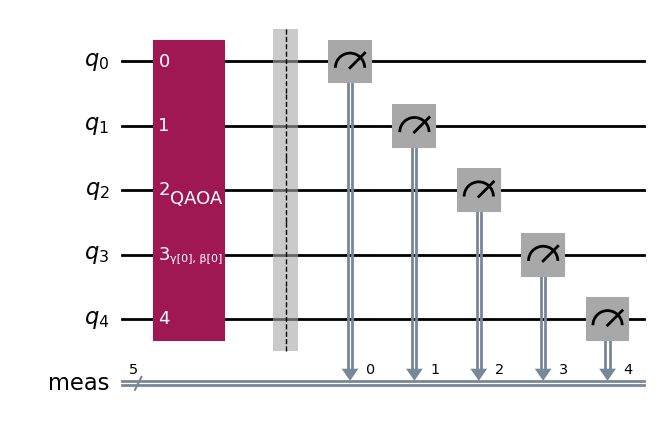

In [14]:
from qiskit.circuit.library import QAOAAnsatz
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=1)
circuit.measure_all()

circuit.draw("mpl")

[2.639, 2.6635]
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -12.18507873031742
       x: [ 2.765e+00  2.762e+00]
    nfev: 16
   maxcv: 0.0
{'11010': 0.22675, '00110': 0.0175, '00111': 0.04925, '00011': 0.14975, '00101': 0.08425, '11100': 0.1575, '00010': 0.04725, '01100': 0.04275, '01110': 0.016, '00100': 0.0245, '01101': 0.02, '11110': 0.047, '10010': 0.033, '01011': 0.01325, '01111': 0.0075, '00000': 0.00275, '01010': 0.01775, '01000': 0.00275, '10110': 0.003, '10100': 0.00275, '10101': 0.00325, '10001': 0.00025, '00001': 0.00625, '10111': 0.00275, '10011': 0.01275, '11111': 0.00025, '01001': 0.00025, '11011': 0.0025, '11001': 0.00075, '10000': 0.003, '11101': 0.0025, '11000': 0.00025}


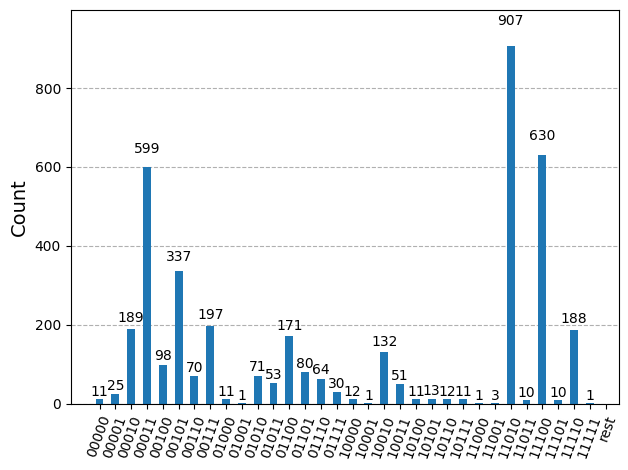

In [ ]:
from qiskit.circuit.library import QAOAAnsatz
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=1)
circuit.measure_all()

circuit.draw("mpl")
circuit.parameters

#################
#Simulator Backend
#############

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Lokaler Simulator (nutzt deine CPU)
simulator_backend = AerSimulator()
# Der Estimator nutzt nun den Simulator
# Tipp: Wir reduzieren die Shots für schnellere Tests am Anfang
estimator = Estimator(mode=simulator_backend)
options = {"default_shots": 1024}
pm = generate_preset_pass_manager(optimization_level=3,backend=simulator_backend)
candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)


beta = 2.6390
gamma = 2.6635
init_params = [beta, gamma]


print(init_params)

from qiskit import QuantumCircuit
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.primitives.containers.observables_array import ObservablesArrayLike
objective_func_vals = []  # Global variable
def cost_func_estimator(
    params: list,
    ansatz: QuantumCircuit,
    hamiltonian: ObservablesArrayLike,
    estimator: Estimator,
) -> float:
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits for the backend.
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    return cost

from scipy.optimize import minimize
estimator = Estimator(mode=simulator_backend, options={"default_shots": 4_000})
bounds = [(0, np.pi), (0, np.pi)]
result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA", 
    bounds=bounds,
    tol=1e-3,
    options={"rhobeg": 1e-1},
)
print(result)
optimized_circuit = candidate_circuit.assign_parameters(init_params)           #result.x)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=simulator_backend, options={"default_shots": 4_000})
pub = (optimized_circuit)
job = sampler.run([pub])
counts_bin = job.result()[0].data.meas.get_counts()
shots = job.result()[0].data.meas.num_shots
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_bin)

from qiskit.visualization import plot_histogram
plot_histogram(counts_bin, number_to_keep=50)


In [25]:
import numpy as np
import math
from qiskit_ibm_runtime import SamplerV2 as Sampler

# 1. Definiere den Suchbereich (im Bogenmaß)
# Wir scannen Beta von 0.1 bis 0.8 und Gamma von 0.1 bis 0.6
beta_range = np.linspace(2.59, 2.99, 50) 
gamma_range = np.linspace(2.59, 2.99, 50)

target_bitstring = '11010'
results_grid = []

sampler = Sampler(mode=simulator_backend, options={"default_shots": 8192})

print(f"Starte Grid Search für Ziel: {target_bitstring}...")

for b in beta_range:
    for g in gamma_range:
        # Parameter zuweisen (Reihenfolge: Index 0=beta, Index 1=gamma)
        bound_circuit = candidate_circuit.assign_parameters([b, g])
        
        # Job ausführen
        job = sampler.run([bound_circuit])
        result = job.result()[0]
        counts = result.data.meas.get_counts()
        
        # Wahrscheinlichkeit für den Ziel-Bitstring berechnen
        target_counts = counts.get(target_bitstring, 0)
        prob = target_counts / 8192
        
        results_grid.append((b, g, prob))

# 2. Finde die beste Kombination
best_run = max(results_grid, key=lambda x: x[2])

print("-" * 30)
print(f"BESTE KOMBINATION GEFUNDEN:")
print(f"Beta (Index 0): {best_run[0]:.4f} (rad) | {math.degrees(best_run[0]):.2f}°")
print(f"Gamma (Index 1): {best_run[1]:.4f} (rad) | {math.degrees(best_run[1]):.2f}°")
print(f"Wahrscheinlichkeit für {target_bitstring}: {best_run[2]*100:.2f}%")
print("-" * 30)

Starte Grid Search für Ziel: 11010...
------------------------------
BESTE KOMBINATION GEFUNDEN:
Beta (Index 0): 2.6390 (rad) | 151.20°
Gamma (Index 1): 2.6635 (rad) | 152.61°
Wahrscheinlichkeit für 11010: 24.98%
------------------------------


In [62]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])

qiskit_runtime_service.__init__:WARNING:2026-01-02 14:08:30,406: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-01-02 14:08:30,887: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2026-01-02 14:08:33,070: Using instance: open-instance, plan: open


<IBMBackend('ibm_fez')>


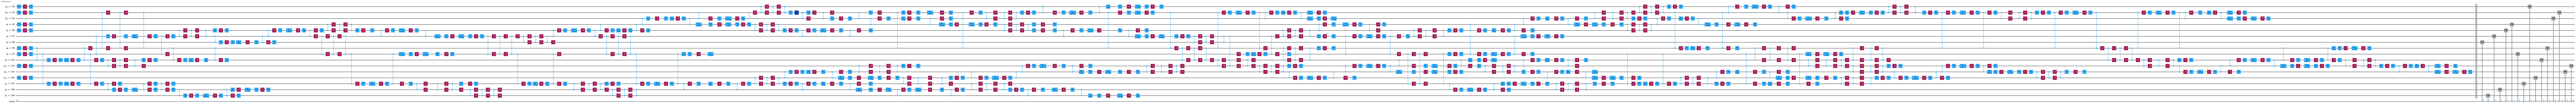

In [13]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
print(backend)
 
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
 
candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

#from qiskit_aer import AerSimulator

#backend = AerSimulator()
#pm = generate_preset_pass_manager(optimization_level=0,backend=backend)
#candidate_circuit = pm.run(circuit)
#candidate_circuit.draw("mpl", fold=False, idle_wires=False)

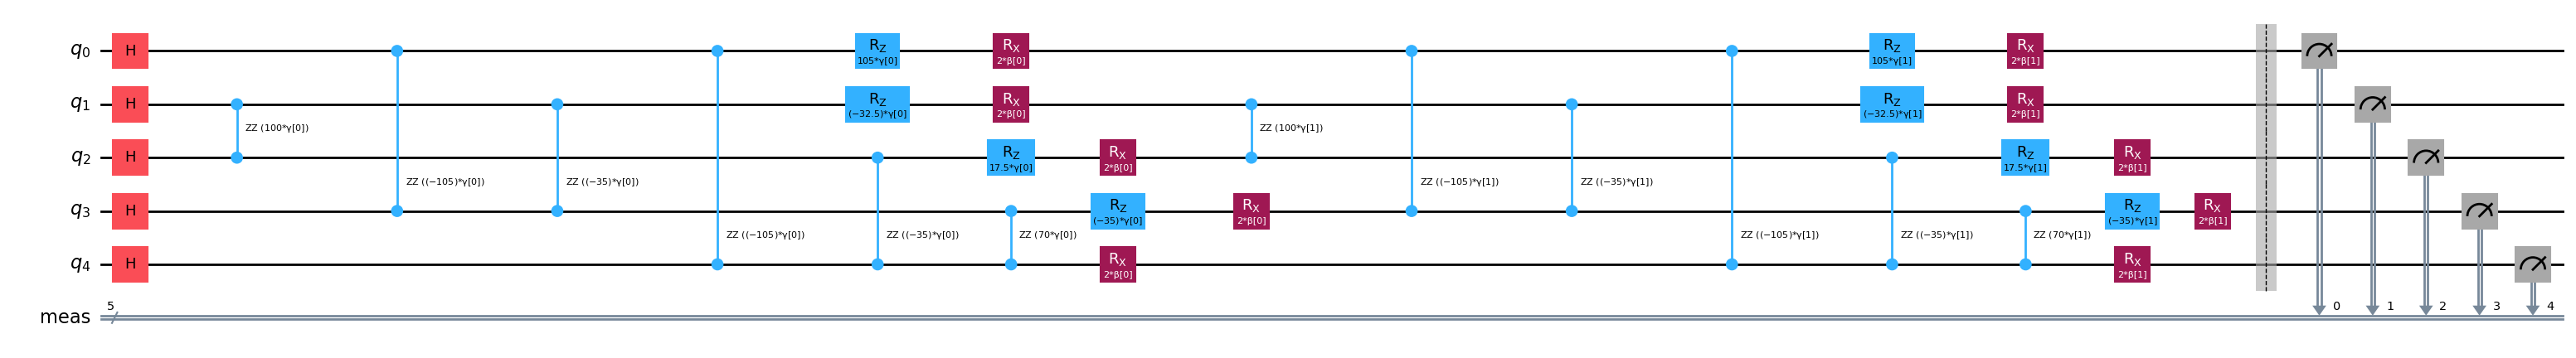

In [34]:
#################

#Simulator Backend
#############

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Lokaler Simulator (nutzt deine CPU)
simulator_backend = AerSimulator()

# Der Estimator nutzt nun den Simulator
# Tipp: Wir reduzieren die Shots für schnellere Tests am Anfang
estimator = Estimator(mode=simulator_backend)
options = {"default_shots": 1024}

pm = generate_preset_pass_manager(optimization_level=3,backend=simulator_backend)
candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [42]:
init_params = [0.3,0.3, 0.3,0.3]
print(init_params)

[0.3, 0.3, 0.3, 0.3]


In [43]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.primitives.containers.observables_array import ObservablesArrayLike

objective_func_vals = []  # Global variable


def cost_func_estimator(
    params: list,
    ansatz: QuantumCircuit,
    hamiltonian: ObservablesArrayLike,
    estimator: Estimator,
) -> float:
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits for the backend.
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

In [44]:
from scipy.optimize import minimize

estimator = Estimator(mode=simulator_backend, options={"default_shots": 4_000})

bounds = [(0, np.pi), (0, np.pi),(0, np.pi), (0, np.pi)]
result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA", 
    bounds=bounds,
    tol=1e-3,
    options={"rhobeg": 1e-1},
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -48.93964008997751
       x: [ 4.681e-01  3.557e-01  4.460e-01  1.842e-01]
    nfev: 32
   maxcv: 0.0


In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
print("="*60)
print("WAHRSCHEINLICHKEITSVERTEILUNG BERECHNEN")
print("="*60)
optimal_params = result.x
qc_optimal = candidate_circuit.assign_parameters(optimal_params)
qc_optimal.measure_all()
sampler = Sampler(mode=simulator_backend)
job = sampler.run([qc_optimal], shots=4000)
result_sampler = job.result()
counts = result_sampler[0].data.meas.get_counts()
shots = sum(counts.values())
print(f"✓ {len(counts)} verschiedene Bitstrings gemessen")
print(f"✓ Total shots: {shots}")
energy_distribution = defaultdict(float)
for bitstring, count in counts.items():
    x = np.array([int(bit) for bit in bitstring])
    energy = float(x @ Q @ x)
    prob = count / shots
    energy_distribution[energy] += prob
energies = sorted(energy_distribution.keys())
probs = [energy_distribution[e] for e in energies]
print(f"✓ {len(energies)} verschiedene Energie-Levels")
print(f"✓ Minimale Energie: {min(energies):.2f}")
print(f"✓ Maximale Energie: {max(energies):.2f}")
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
ax1 = axes[0]
beta_values = optimal_params[:len(optimal_params)//2]
ax1.plot(range(1, len(beta_values)+1), beta_values, 'bo-', linewidth=2, markersize=8)
ax1.set_ylabel('β', fontsize=14, fontweight='bold')
ax1.set_xticks(range(1, len(beta_values)+1))
ax1.grid(True, alpha=0.3)
ax1.set_title('Optimierte QAOA Parameter und Energieverteilung', fontsize=16, fontweight='bold')
ax2 = axes[1]
gamma_values = optimal_params[len(optimal_params)//2:]
ax2.plot(range(1, len(gamma_values)+1), gamma_values, 'ro-', linewidth=2, markersize=8)
ax2.set_ylabel('γ', fontsize=14, fontweight='bold')
ax2.set_xticks(range(1, len(gamma_values)+1))
ax2.grid(True, alpha=0.3)
ax3 = axes[2]
sorted_pairs = sorted(energy_distribution.items(), key=lambda x: x[0])[:10]
top_energies = [e for e, p in sorted_pairs]
top_probs = [p for e, p in sorted_pairs]
bars = ax3.bar(range(len(top_energies)), top_probs, color='green', alpha=0.7, edgecolor='black')
bars[0].set_color('darkgreen')  # Beste Lösung hervorheben
bars[0].set_alpha(0.9)
ax3.set_xlabel('Energy Level', fontsize=14, fontweight='bold')
ax3.set_ylabel('Probability', fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(top_energies)))
ax3.set_xticklabels([f'{e:.1f}' for e in top_energies], rotation=45, ha='right')
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim(0, max(top_probs) * 1.1)
plt.tight_layout()
plt.savefig('qaoa_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n" + "="*60)
print("ZUSAMMENFASSUNG")
print("="*60)
print(f"Optimierte β: {beta_values}")
print(f"Optimierte γ: {gamma_values}")
print(f"\nBeste gefundene Energie: {min(energies):.2f}")
print(f"Wahrscheinlichkeit: {energy_distribution[min(energies)]:.2%}")
print(f"\nCPLEX Optimum: -395.00")
print(f"Approximation Ratio: {min(energies)/-395:.1%}")

print(f"\n{'Top-5 Energie-Levels:':<30}")
print("-"*60)
for i, (energy, prob) in enumerate(sorted_pairs[:5], 1):
    print(f"{i}. Energie: {energy:7.2f} | Wahrscheinlichkeit: {prob:6.2%}")
print("="*60)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

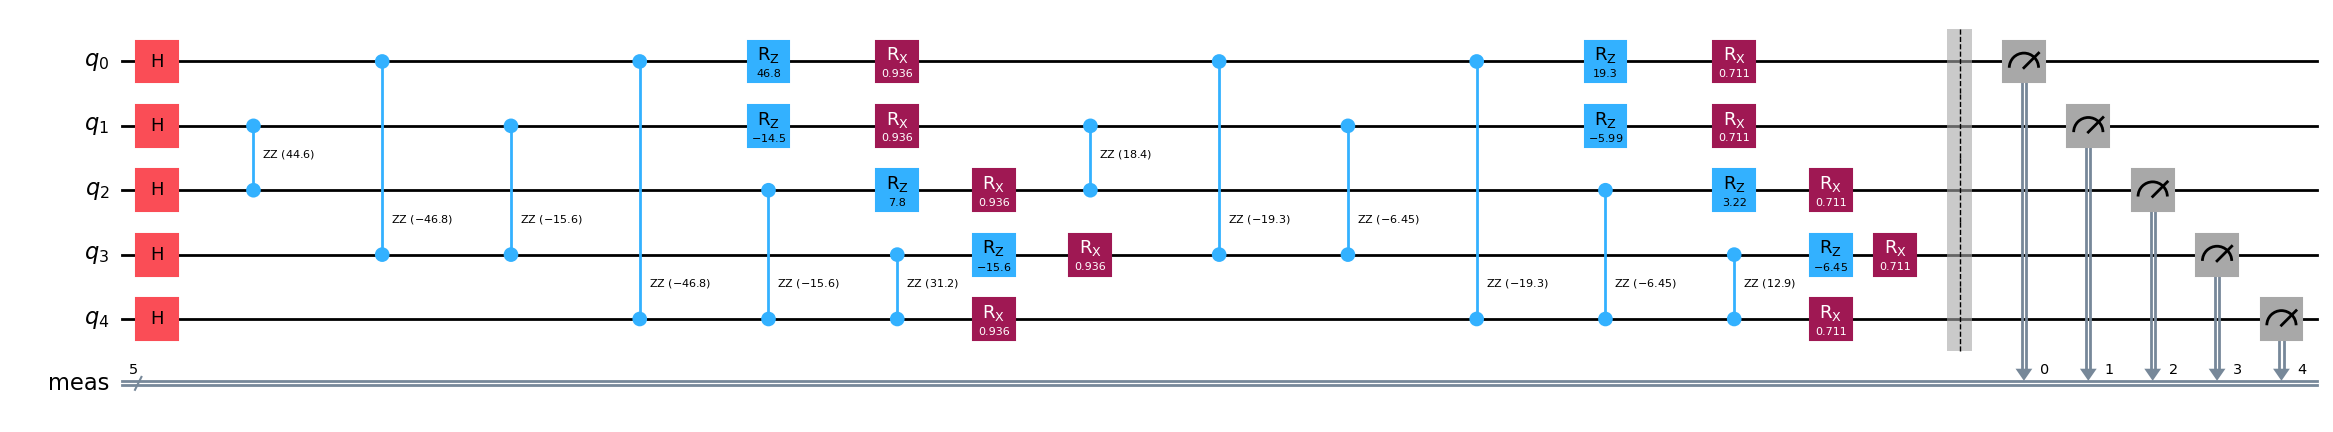

In [45]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=simulator_backend, options={"default_shots": 4_000})

pub = (optimized_circuit)
job = sampler.run([pub])


In [47]:
counts_bin = job.result()[0].data.meas.get_counts()
shots = job.result()[0].data.meas.num_shots
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_bin)

{'00100': 0.09625, '01001': 0.06125, '10100': 0.09825, '01101': 0.099, '10000': 0.07375, '11101': 0.083, '00000': 0.08725, '10101': 0.05925, '11110': 0.00125, '00001': 0.032, '11100': 0.0405, '01110': 0.001, '01011': 0.00725, '10001': 0.03825, '11001': 0.05475, '01100': 0.03825, '11011': 0.00975, '10010': 0.005, '00101': 0.039, '00011': 0.00175, '01010': 0.00425, '00010': 0.0045, '11000': 0.025, '01000': 0.02125, '00110': 0.0025, '10111': 0.003, '01111': 0.00125, '10110': 0.00325, '11111': 0.002, '10011': 0.003, '00111': 0.0005, '11010': 0.00275}


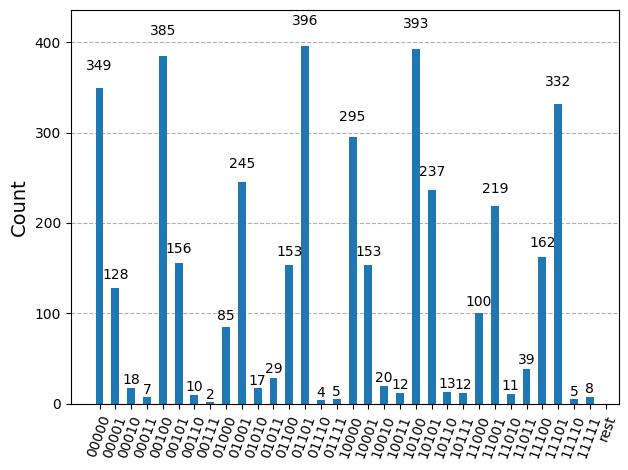

In [48]:
from qiskit.visualization import plot_histogram
plot_histogram(counts_bin, number_to_keep=50)

In [54]:
def classical_cost_fun(bit_str: str, Q: np.ndarray) -> float:
    x = np.array([int(bit) for bit in bit_str])
    return float(x @ Q @ x)  # float() um sicherzugehen

# Beste Lösungen finden
min_energy = float('inf')
best_solutions = []

for bit_str in counts_bin.keys():
    energy = classical_cost_fun(bit_str, Q)
    if energy < min_energy:
        min_energy = energy
        best_solutions = [bit_str]
    elif abs(energy - min_energy) < 1e-6:  # Gleiche Energie
        best_solutions.append(bit_str)

print(f"Minimale Energie: {min_energy:.2f}")
print(f"Anzahl beste Lösungen: {len(best_solutions)}")
print(f"Beste Lösung: {best_solutions[0]}")
print(best_solutions)

Minimale Energie: -99.00
Anzahl beste Lösungen: 1
Beste Lösung: 11010
['11010']


In [24]:
# Prüfen ob der beste Bitstring in den Messungen war
best_bitstring = best_solutions[0]
print(f"Beste Lösung: {best_bitstring}")
print(f"War in Messungen? {best_bitstring in counts_bin}")
if best_bitstring in counts_bin:
    print(f"Häufigkeit: {counts_bin[best_bitstring]}")

# Alternative: Top 10 Lösungen mit ihren Häufigkeiten
print("\n" + "="*80)
print("TOP 10 LÖSUNGEN aus den tatsächlichen Messungen")
print("="*80)

energy_list = []
for bit_str, count in counts_bin.items():
    x = np.array([int(bit) for bit in bit_str])
    energy = float(x @ Q @ x)
    energy_list.append((bit_str, energy, count))

# Nach Energie sortieren
energy_list.sort(key=lambda x: x[1])

# Top 10 anzeigen
for i, (bit_str, energy, count) in enumerate(energy_list[:10], 1):
    prob = count / shots
    print(f"{i}. Bitstring: {bit_str}")
    print(f"   Energie: {energy:.2f} | Häufigkeit: {count}/{shots} ({prob*100:.2f}%)")
    print()

Beste Lösung: 11010
War in Messungen? True
Häufigkeit: 22

TOP 10 LÖSUNGEN aus den tatsächlichen Messungen
1. Bitstring: 11010
   Energie: -19.00 | Häufigkeit: 22/4000 (0.55%)

2. Bitstring: 10101
   Energie: -16.00 | Häufigkeit: 104/4000 (2.60%)

3. Bitstring: 11001
   Energie: -12.00 | Häufigkeit: 295/4000 (7.38%)

4. Bitstring: 11000
   Energie: -12.00 | Häufigkeit: 34/4000 (0.85%)

5. Bitstring: 10110
   Energie: -9.00 | Häufigkeit: 56/4000 (1.40%)

6. Bitstring: 10100
   Energie: -9.00 | Häufigkeit: 31/4000 (0.78%)

7. Bitstring: 01000
   Energie: -9.00 | Häufigkeit: 1/4000 (0.03%)

8. Bitstring: 00100
   Energie: -6.00 | Häufigkeit: 204/4000 (5.10%)

9. Bitstring: 11101
   Energie: -5.00 | Häufigkeit: 131/4000 (3.28%)

10. Bitstring: 11011
   Energie: -5.00 | Häufigkeit: 107/4000 (2.67%)



In [25]:
def decode_solution(bit_str: str, tasks, robots, slots):
    """
    Dekodiert den Bitstring zurück zu Task-Zuweisungen
    
    Variablen-Struktur (basierend auf typischer QUBO-Formulierung):
    - x-Variablen: Task → Robot Zuweisung
    - y-Variablen: Task → Zeitslot Zuweisung
    - w-Variablen: Task → (Robot, Zeitslot) kombinierte Zuweisung
    """
    x_bits = [int(bit) for bit in bit_str]
    
    n_tasks = len(tasks)
    n_robots = len(robots)
    n_slots = len(slots)
    
    # Variablen-Indexierung (anpassen an Ihre Struktur!)
    X_assignments = []
    Y_assignments = []
    W_assignments = []
    
    idx = 0
    
    # X-Variablen: Task → Robot (n_tasks × n_robots Variablen)
    for t_idx, task in enumerate(tasks):
        for r_idx, robot in enumerate(robots):
            if x_bits[idx] == 1:
                X_assignments.append(('x', task['name'], robot))
            idx += 1
    
    # Y-Variablen: Task → Slot (n_tasks × n_slots Variablen)
    for t_idx, task in enumerate(tasks):
        for s_idx, slot in enumerate(slots):
            if x_bits[idx] == 1:
                Y_assignments.append(('y', task['name'], slot))
            idx += 1
    
    # W-Variablen: Task → (Robot, Slot) (n_tasks × n_robots × n_slots)
    for t_idx, task in enumerate(tasks):
        for r_idx, robot in enumerate(robots):
            for s_idx, slot in enumerate(slots):
                if idx < len(x_bits) and x_bits[idx] == 1:
                    W_assignments.append(('w', task['name'], robot, slot))
                idx += 1
    
    return X_assignments, Y_assignments, W_assignments


# Ihre Problem-Daten (aus der JSON-Config)
tasks = [
    {"name": "T0", "p": 1},
    {"name": "T1", "p": 2},
    {"name": "T2", "p": 1}

]
robots = ["R1", "R2"]
slots = [0, 1, 2]

# Dekodierung
best_solution = best_solutions[0]
X, Y, W = decode_solution(best_solution, tasks, robots, slots)

print("="*60)
print("LÖSUNG DEKODIERT")
print("="*60)
print(f"\nBitstring: {best_solution}")
print(f"Energie: {min_energy:.2f}")
print(f"\nX=1: {X}")
print(f"Y=1: {Y}")
print(f"W=1: {W}")
print("="*60)

# Schöne Darstellung
print("\n" + "="*60)
print("SCHEDULING PLAN")
print("="*60)
for task in tasks:
    task_name = task['name']
    
    # Zugewiesener Robot
    robot = [x[2] for x in X if x[1] == task_name]
    robot_str = robot[0] if robot else "NICHT ZUGEWIESEN"
    
    # Zugewiesener Slot
    slot = [y[2] for y in Y if y[1] == task_name]
    slot_str = str(slot[0]) if slot else "NICHT ZUGEWIESEN"
    
    print(f"{task_name}: Robot={robot_str}, Zeitslot={slot_str}")

print("="*60)

IndexError: list index out of range

In [ ]:
# Analyse der Variablen-Struktur
print(f"Bitstring-Länge: {len(best_solution)}")
print(f"Anzahl Tasks: {len(tasks)}")
print(f"Anzahl Robots: {len(robots)}")
print(f"Anzahl Slots: {len(slots)}")

n_x_vars = len(tasks) * len(robots)  # Task → Robot
n_y_vars = len(tasks) * len(slots)   # Task → Slot
n_w_vars = len(tasks) * len(robots) * len(slots)  # Task → (Robot, Slot)

print(f"\nErwartete Variablen:")
print(f"X-Variablen (Task→Robot): {n_x_vars}")
print(f"Y-Variablen (Task→Slot): {n_y_vars}")
print(f"W-Variablen (Task→Robot→Slot): {n_w_vars}")
print(f"Gesamt erwartet: {n_x_vars + n_y_vars + n_w_vars}")

# Schauen Sie sich die tatsächliche QUBO-Größe an
print(f"\nTatsächliche QUBO-Größe: {Q.shape[0]}")

# Einfache Dekodierung (nur basierend auf tatsächlichen Variablen)
def decode_simple(bit_str: str, tasks, robots, slots):
    """Vereinfachte Dekodierung ohne Annahmen über Struktur"""
    x_bits = [int(bit) for bit in bit_str]
    n_vars = len(x_bits)
    
    print(f"\nAktive Variablen (Index: Wert):")
    for i, bit in enumerate(x_bits):
        if bit == 1:
            print(f"  x[{i}] = 1")
    
    return x_bits

x_solution = decode_simple(best_solution, tasks, robots, slots)

In [26]:
from old.decode_best_solution import invert_map, decode_sample

inv_x = invert_map(x)        # idx -> (tname, rname)
inv_y = invert_map(y)        # idx -> (tname, z)
inv_w = invert_map(w) 

sample = {i: int(round(v)) for i, v in enumerate(result.x)}
#sample = {int(k): int(v) for k, v in sampleset.first.sample.items()}
chosen_x, chosen_y, chosen_w = decode_sample(sample, inv_x, inv_y, inv_w)
print("X=1:", chosen_x)
print("Y=1:", chosen_y)
print("W=1:", chosen_w)

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Derive robots and tasks
robots = sorted({r for _, t, r in chosen_x} | {r for _, t, r, z in chosen_w})
tasks = sorted({t for _, t, r in chosen_x} | {t for _, t, z in chosen_y} | {t for _, t, r, z in chosen_w})
slots = sorted({z for _, t, r, z in chosen_w} | {z for _, t, z in chosen_y})

# Build schedule table: rows = time slots, columns = robots, value = list of tasks running
schedule = {r: {z: [] for z in slots} for r in robots}
for _, t, r, z in chosen_w:
    schedule[r][z].append(t)

df = pd.DataFrame({r: [", ".join(schedule[r][z]) if schedule[r][z] else "" for z in slots] for r in robots},
                  index=slots)
df.index.name = "Time slot"

# Detect conflicts (more than one task on the same robot & time slot)
conflicts = []
for r in robots:
    for z in slots:
        if len(schedule[r][z]) > 1:
            conflicts.append((r, z, schedule[r][z]))

# Display the schedule table to the user
#from caas_jupyter_tools import display_dataframe_to_user
#display_dataframe_to_user("Theoretischer Arbeitsplan (Slots × Roboter)", df)

# Build a simple Gantt-like chart per robot (horizontal bars for each task segment)
# We'll draw each task segment as a single-slot bar (duration = 1) wherever w=1.
# If tasks span consecutive slots, they will appear as adjacent bars.
fig, ax = plt.subplots(figsize=(8, 2 + 0.6*len(robots)))

# Map robots to lanes
robot_to_lane = {r: i for i, r in enumerate(robots)}

# Collect segments: (lane, start, duration, label)
segments = []
for _, t, r, z in chosen_w:
    lane = robot_to_lane[r]
    segments.append((lane, z, 1, f"{t}@{r}"))

# -------- NEU: konsistente Farben pro (Task, Roboter) --------
# Alle Labels (t@r), stabil sortiert -> Farbindex
labels = sorted({lbl for _, _, _, lbl in segments})
cmap = plt.cm.get_cmap('tab20', max(20, len(labels)))  # diskrete Palette
label_to_color = {lbl: cmap(i % cmap.N) for i, lbl in enumerate(labels)}

# Draw bars mit konsistenten Farben
for lane, start, dur, label in segments:
    ax.barh(lane, dur, left=start, color=label_to_color[label], edgecolor='black', linewidth=0.5)
    ax.text(start + dur/2, lane, label, va='center', ha='center', fontsize=9)




ax.set_yticks(list(robot_to_lane.values()), list(robot_to_lane.keys()))
ax.set_xlabel("Time slot")
ax.set_ylabel("Roboter")
ax.set_title("Gantt-Übersicht (1 Slot = 1 Zeiteinheit)")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Prepare a short textual summary of assignments and conflicts
summary_lines = []
summary_lines.append("Zuordnung x (Task → Roboter):")
for _, t, r in chosen_x:
    summary_lines.append(f"  - {t} → {r}")
summary_lines.append("Startslots y (Task → Startslot):")
for _, t, z in chosen_y:
    summary_lines.append(f"  - {t} beginnt bei Slot {z}")
summary_lines.append("Belegte Slots w (Task, Roboter, Slot):")
for _, t, r, z in sorted(chosen_w, key=lambda e: (e[2], e[3], e[1])):
    summary_lines.append(f"  - {r} bei Slot {z}: {t}")

if conflicts:
    summary_lines.append("⚠️ Konflikte erkannt (mehr als ein Task auf demselben Roboter im selben Slot):")
    for r, z, ts in conflicts:
        summary_lines.append(f"  - {r} Slot {z}: {', '.join(ts)}")
else:
    summary_lines.append("Keine Konflikte erkannt.")

print("\n".join(summary_lines))

NameError: name 'chosen_x' is not defined